# 1. Data and Pre-processing

## 1.1 Libraries

In [1]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [29]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras_tuner.tuners import RandomSearch
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
tf.__version__

'2.9.2'

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
np.random.seed(101)
tf.random.set_seed(101)
keras.utils.set_random_seed(101)

## 1.2 Dataset Classes and Example

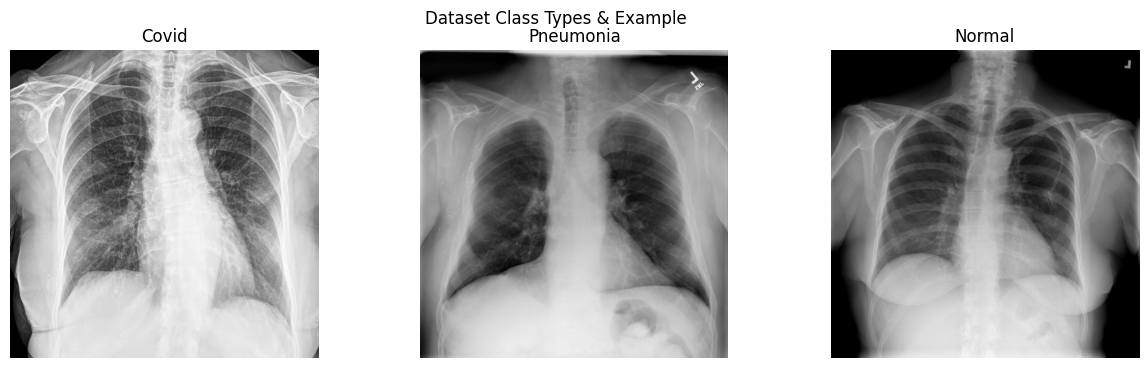

In [7]:
img1 = [f"data/train/covid/COVID-19 (2).png", 
        f"data/train/pneumonia/00000165_001.png",
        f"data/train/normal/00000005_003.png"]

fig = plt.figure(figsize = (15,4))

for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.imshow(cv2.imread(img1[i]))
    plt.axis('off')

plt.subplot(1,3,1)
plt.title("Covid")

plt.subplot(1,3,2)
plt.title("Pneumonia")

plt.subplot(1,3,3)
plt.title("Normal")

plt.suptitle("Dataset Class Types & Example")
plt.show()

In [8]:
target_size = (224, 224)
batch_size = 20

In [9]:
train_generator = image_dataset_from_directory(
    directory = 'data/train',
    image_size = target_size,
    batch_size = batch_size,
    labels="inferred",
    label_mode ='categorical',
    shuffle = True)

val_generator = image_dataset_from_directory(
    directory = 'data/val',
    image_size = target_size,
    batch_size = batch_size,
    labels="inferred",
    label_mode ='categorical',
    shuffle = True)

test_generator = image_dataset_from_directory(
    directory = 'data/test',
    image_size = target_size,
    batch_size = batch_size,
    labels="inferred",
    label_mode = 'categorical',
    shuffle = False)

Found 9000 files belonging to 3 classes.
Found 540 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [10]:
print(f'Training Data Labels: {train_generator.class_names}')
print(f'Validation Data Labels: {val_generator.class_names}')
print(f'Test Data Labels: {test_generator.class_names}')

Training Data Labels: ['covid', 'normal', 'pneumonia']
Validation Data Labels: ['covid', 'normal', 'pneumonia']
Test Data Labels: ['covid', 'normal', 'pneumonia']


In [11]:
train_generator = train_generator.map(lambda x, y: (preprocess_input(x), y))
val_generator = val_generator.map(lambda x, y: (preprocess_input(x), y))
test_generator = test_generator.map(lambda x, y: (preprocess_input(x), y))

# 2. Pre-trained Models

In [12]:
#Ref: https://github.com/keras-team/keras/issues/5337
'''
This code is taken from the above reference, and is 
used to dynamically allocate memory to GPU making it
available for each tensorflow operation. This code is
making sure the below code runs without issues.
'''

from tensorflow.compat.v1.keras.backend import set_session


config = tf.compat.v1.ConfigProto()

# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True  

# to log device placement(on which device the operation ran)
config.log_device_placement = True 

In [13]:
#https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
'''
By enabling GPU memory growth, TensorFlow will allocate memory 
on an as-needed basis rather than pre-allocating the entire 
GPU memory. This can help prevent out-of-memory errors.
'''
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [14]:
def MobileNetCustomSVM():
    mobilenet_base = MobileNetV2(weights = 'imagenet', 
                                include_top = False,
                                input_shape = (224, 224, 3))
    mobilenet_base.trainable = False

    classifier_layers = [
        layers.Flatten(),
        layers.Dropout(rate = 0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'), 
        layers.Dense(3, activation='softmax',
                     kernel_regularizer=regularizers.l2(0.01))
    ]

    # All layers in `model` are now frozen
    assert mobilenet_base.trainable == False
    # `trainable` is propagated recursively
    assert mobilenet_base.layers[0].trainable == False

    mobilenet_model = tf.keras.Sequential([
        mobilenet_base,
        *classifier_layers
    ])
    return mobilenet_model

In [43]:
def build_model(hp):
    lr = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'adadelta', 'rmsprop'])

    model = MobileNetCustomSVM()
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SquaredHinge(),
                  metrics=['accuracy'])
    return model

In [44]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='hpo'
)

INFO:tensorflow:Reloading Tuner from my_dir\hpo\tuner0.json


In [45]:
input = next(iter(train_generator))
X = input[0]
y = input[1]
print(X.shape)
print(y.shape)

(20, 224, 224, 3)
(20, 3)


In [46]:
tuner.search(X, y, validation_split=0.2, epochs=10)

Trial 9 Complete [00h 00m 05s]
val_accuracy: 0.25

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 34s
INFO:tensorflow:Oracle triggered exit


In [53]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Print the best results
best_score = tuner.oracle.get_best_trials(1)[0].score
best_params = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
print("Best: %f using %s" % (best_score, best_params))

Best: 1.000000 using {'learning_rate': 0.001, 'optimizer': 'adadelta'}


In [17]:
class ValidationLoggerCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ValidationLoggerCallback, self).__init__()
        self.best_val_loss = np.inf

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            print(f'\nValidation Loss improved: {val_loss:.4f}')
        else:
            print(f'\nValidation Loss not improved, Best val_loss: {self.best_val_loss:.4f}')

vlc = ValidationLoggerCallback()

es = EarlyStopping(monitor='val_loss', mode='min',patience=20,
                   restore_best_weights=True, verbose = 1)

In [18]:
# Create a basic model instance
mobilenet_model = MobileNetCustomSVM()

mobilenet_model.compile(loss = keras.losses.SquaredHinge(),
                optimizer = keras.optimizers.Adadelta(learning_rate=0.001),
                metrics = ['accuracy'])
# Display the model's architecture
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                        

In [19]:
tf.keras.backend.clear_session()
sess = tf.compat.v1.Session(config=config)
set_session(sess)

with tf.device("/GPU:0"):
    svm_mobilenet_hist = mobilenet_model.fit(train_generator,
                                        steps_per_epoch = 9000/20,
                                        epochs = 100,
                                        validation_data = val_generator,
                                        validation_steps = 540/20,
                                        callbacks=[vlc,
                                                   es],
                                        shuffle = True)
    
mobilenet_model.save_weights('./models/svm_model_weights')
json.dump(svm_mobilenet_hist.history, open('Objects/svm_results', 'w'))

sess.close()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6

Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: 1.1304 - accuracy: 0.6850
Validation Loss improved: 1.1100
450/450 [==============================] - 26s 32ms/step - loss: 1.1304 - accuracy: 0.6850 - val_loss: 1.1100 - val_accuracy: 0.6907
Epoch 2/100
448/450 [============================>.] - ETA: 0s - loss: 0.9394 - accuracy: 0.8465
Validation Loss improved: 1.0643
450/450 [==============================] - 14s 30ms/step - loss: 0.9399 - accuracy: 0.8460 - val_loss: 1.0643 - val_accuracy: 0.7204
Epoch 3/100
448/450 [============================>.] - ETA: 0s - loss: 0.8920 - accuracy: 0.8804
Validation Loss improved: 1.0243
450/450 [==============================] - 13s 28ms/step - loss: 0.8916 - accuracy: 0.8807 - val_loss: 1.0243 - val_accuracy: 0.7593
Epoch 4/100
449/450 [======================

In [15]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [16]:
# Loads the weights
mobilenet_model = MobileNetCustomSVM()
mobilenet_model.load_weights('./models/svm_model_weights') 

svm_mobilenet_hist = json.load(open('Objects/svm_results', 'r'))

mobilenet_model.compile(loss = keras.losses.SquaredHinge(),
                optimizer = keras.optimizers.Adadelta(learning_rate=0.001),
                metrics = ['accuracy', auroc])

In [17]:
print(type(mobilenet_model))
print(type(svm_mobilenet_hist))

<class 'keras.engine.sequential.Sequential'>
<class 'dict'>


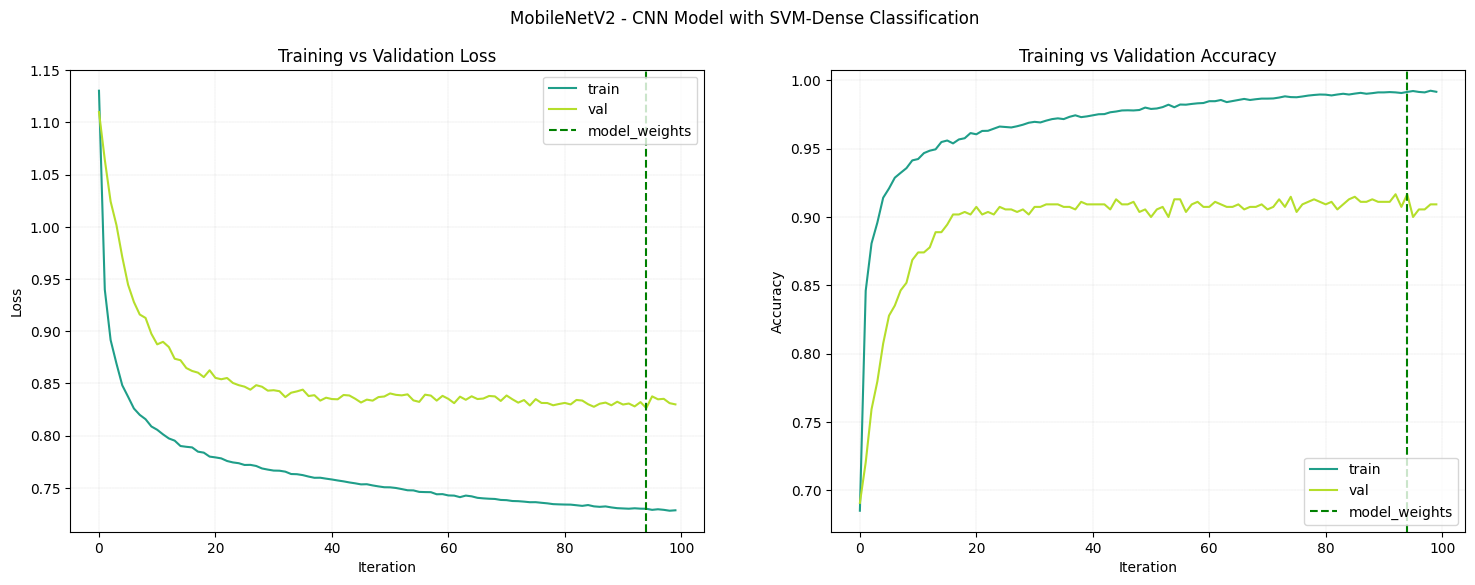

In [18]:
lowest = np.amin(svm_mobilenet_hist['val_loss'])
time = np.where(svm_mobilenet_hist['val_loss'] == lowest)

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(svm_mobilenet_hist['loss'], color='#1f9e89')
ax1.plot(svm_mobilenet_hist['val_loss'], color='#b5de2b')
ax1.axvline(x=time, color='green', linestyle='--')
ax1.set_title('Training vs Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.grid(color='grey', linestyle='--', linewidth=0.1)
ax1.legend(['train', 'val', 'model_weights'], loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(svm_mobilenet_hist['accuracy'], color='#1f9e89')
ax2.plot(svm_mobilenet_hist['val_accuracy'], color='#b5de2b')
ax2.axvline(x=time, color='green', linestyle='--')
ax2.set_title('Training vs Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Iteration')
ax2.grid(color='grey', linestyle='--', linewidth=0.1)
ax2.legend(['train', 'val', 'model_weights'], loc='lower right')

plt.suptitle("MobileNetV2 - CNN Model with SVM-Dense Classification")
plt.show()

In [19]:
svm_predictions = mobilenet_model.predict(test_generator)

15/15 [==============================] - 8s 30ms/step


In [20]:
svm_predictions= np.array(tf.argmax(svm_predictions, axis=1))
y_test = np.array(tf.argmax(np.concatenate([y for _, y in test_generator], axis=0), 
                   axis = 1))

In [21]:
assert svm_predictions.shape == y_test.shape

In [22]:
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       100
           1       0.83      0.98      0.90       100
           2       1.00      0.86      0.92       100

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300



In [30]:
f1 = f1_score(y_test, svm_predictions, average='macro')
precision = precision_score(y_test, svm_predictions, average='macro')
recall = recall_score(y_test, svm_predictions, average='macro')
print(f'F1 Score: {f1:.4f}')
print(f'Precision Score: {precision:.4f}')
print(f'Recall Score: {recall:.4f}')

F1 Score: 0.9209
Precision Score: 0.9296
Recall Score: 0.9200


In [24]:
cm = confusion_matrix(y_test, svm_predictions)
class_labels = ["covid", "normal", "pneumonia"]

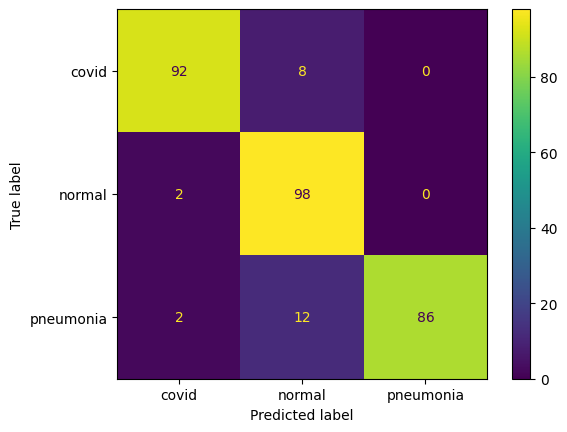

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.viridis)
plt.show()

In [26]:
def idx_to_onehot(idx):
    onehot = {0: [1,0,0], 1: [0,1,0], 2: [0,0,1]}
    return onehot[idx]

In [27]:
y_pred_proba = mobilenet_model.predict(test_generator)


 3/15 [=====>........................] - ETA: 0s

15/15 [==============================] - 0s 20ms/step


In [28]:
auc = roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr') 

print(f'Average AUC: {auc:.4f}')

Average AUC: 0.9882
